In [1]:
# Dataframe 
import pandas as pd
import numpy as np
import math

# Cleaning 
import re
import redditcleaner
from nltk.corpus import stopwords

# Analysis 
import nltk
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('omw-1.4')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Remove Warning 
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/levinadong/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/levinadong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/levinadong/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## Load the data

In [2]:
#df = pd.read_csv('nbs.csv')
df = pd.read_csv('123.csv')

In [3]:
df.head()

,Post ID,Title,Body,Author,Score,Publish Date,Total No. of Comments,Permalink,Unnamed: 8
0,ttekt0,[Conti] Trae Young will start the third quarter.,https://twitter.com/mikeconti929/status/150969...,OO17MVP,1,3/31/22 18:06,0,/r/nba/comments/ttekt0/conti_trae_young_will_s...,NaN
1,tten92,Embiid with the ridiculous eurostep into poste...,https://streamable.com/v6rtdi,maacaack,1,3/31/22 18:10,0,/r/nba/comments/tten92/embiid_with_the_ridicul...,NaN
2,tteo2g,Caruso has scored 7 total points in the last 1...,https://www.reddit.com/r/nba/comments/tteo2g/c...,EH15,1,3/31/22 18:11,0,/r/nba/comments/tteo2g/caruso_has_scored_7_tot...,NaN
3,tteoul,[Highlight] Embiid with the eurostep into post...,https://streamable.com/v6rtdi,maacaack,1,3/31/22 18:12,0,/r/nba/comments/tteoul/highlight_embiid_with_t...,NaN
4,tteqng,[Highlight] Crazy sequence leads to a Jrue Hol...,https://streamable.com/jjxldp,SpeedMalibu,1,3/31/22 18:15,1,/r/nba/comments/tteqng/highlight_crazy_sequenc...,Highlight


## Clean the data

In [4]:
def cleaning_text(column):
    """
    clean the text column
    """
    #Removing stop words
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    df['clean_text'] = df[column].map(lambda x: re.sub(pattern, '', x))
    df['clean_text'] = df['clean_text'].map(redditcleaner.clean)                     #redditclean
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('nan', '', x))          #Removing nan
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('[\n]', '', x))         #Removing new line tabs
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('[,\.*!?/u/]', '', x))  # Remove punctuation
    df['clean_text'] = df['clean_text'].map(lambda x: x.lower())                     # Convert the titles to lowercase
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r'[^\w]', ' ', x))      # Remove all symbols
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r'[0-9]+', '', x))      # Remove all numerical varibles
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub("\s\s+" , " ", x))      # Remove two space
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r'\s+', ' ', x))        # Remove one space
    df['clean_text'] = df['clean_text'].map(lambda x: x.lstrip(' '))                 # Remove whitespace at beginning
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r'\b\w{1,3}\b', '', x)) # Remove words length less than 3
    # Remove duplicate phrase
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', x, flags = re.I))
    # Others 
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('________', '', x))          
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('_________', '', x))
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('____________', '', x))
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('_qqmjvltldhyiy', '', x))
    df['clean_text'] = df['clean_text'].map(lambda x: re.sub('_', '', x))
    
    return df

In [5]:
text = cleaning_text('Title')['clean_text']
text.head()

0                 conti trae yong start third qarter
1                    embiid ridiclos erostep poster 
2             carso scored total points last qarters
3                   highlight embiid erostep poster 
4    highlight crazy seqence leads  holiday  giannis
Name: clean_text, dtype: object

## Labeling the title 

In [6]:
sia = SIA()
results = []

for line in text:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)
    
results[0]

{'neg': 0.0,
 'neu': 1.0,
 'pos': 0.0,
 'compound': 0.0,
 'headline': 'conti trae yong start third qarter'}

In [7]:
df_title = pd.DataFrame.from_records(results)
df_title.head()

,neg,neu,pos,compound,headline
0,0.000,1.000,0.000,0.0000,conti trae yong start third qarter
1,0.000,1.000,0.000,0.0000,embiid ridiclos erostep poster
2,0.000,1.000,0.000,0.0000,carso scored total points last qarters
3,0.000,0.556,0.444,0.3400,highlight embiid erostep poster
4,0.229,0.286,0.486,0.4019,highlight crazy seqence leads holiday giannis


In [8]:
df_title['label'] = 0
df_title.loc[df_title['compound'] > 0.1, 'label'] = 1
df_title.loc[df_title['compound'] == 0, 'label'] = 0
df_title.loc[df_title['compound'] < -0.1, 'label'] = -1
df_title.head()
#df_title['label'].isnull().values.any() Check if there are NaN

,neg,neu,pos,compound,headline,label
0,0.000,1.000,0.000,0.0000,conti trae yong start third qarter,0
1,0.000,1.000,0.000,0.0000,embiid ridiclos erostep poster,0
2,0.000,1.000,0.000,0.0000,carso scored total points last qarters,0
3,0.000,0.556,0.444,0.3400,highlight embiid erostep poster,1
4,0.229,0.286,0.486,0.4019,highlight crazy seqence leads holiday giannis,1


In [9]:
# Top Ten Postitive Title
df_title.sort_values(by='compound', ascending=False)['headline'].head(10)

6069      thanks offered feedback fasting comment  wish...
22766    charles barkley  normally care like golden sta...
6070      clarifies position thanks offered feedback fa...
31548    slater  lacob wiggins  prototypical wing playe...
27538    bill simmons  rssillo show love rockets rookie...
13728    karl anthony towns anthony edwards  really spe...
3488     lebron james  appreciate love love wish done w...
31251    first qestion steph presser what mean finally ...
29801     great tiktok page helping people self improve...
23137    freedom thank throwing coolest birthday party ...
Name: headline, dtype: object

In [10]:
# Top Ten Negative Title
df_title.sort_values(by='compound', ascending=True)['headline'].head(10)

34223    olson  asked mikal bridges negativity fanbase ...
18336     player jerry jedy arrested charges  degree cr...
20661     anyone finding chris  hate extreme  know hate...
33286    kevin drant charles barkley  driver comments  ...
12537    wilson   biggest  playoff travesty brooklyn ne...
10795    steph crry  personal worst  missed game previo...
19495    grant batman williams game   bcks points rebon...
4550      nderrated part jokic season jokic   steals le...
6703       worst griddy  memphis grizzlies   crying sla...
2613     undispted shannon sharpe whether missing playo...
Name: headline, dtype: object

In [11]:
# Check how many total positives and negatives we have in this dataset
df_title.label.value_counts()

 0    18954
 1    13589
-1     5205
Name: label, dtype: int64

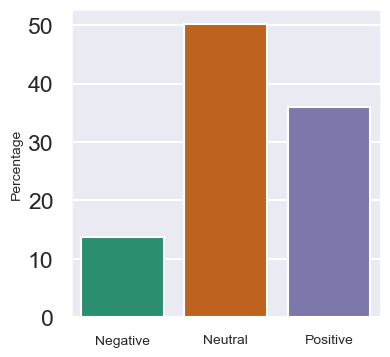

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
counts = df_title.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], size = 10)
ax.set_ylabel("Percentage", size = 10)

plt.show()

## Word Distributions

In [13]:
# Tokenization
stop_words = stopwords.words('english')

def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = word_tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

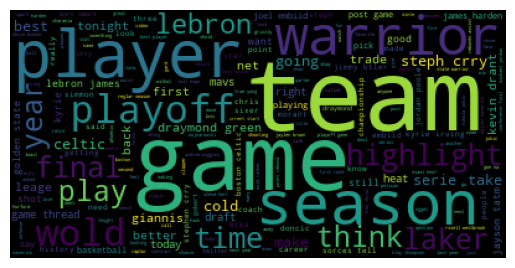

In [14]:
# Overall 
pos_lines = list(df_title.headline)
pos_tokens = process_text(pos_lines)

wml = WordNetLemmatizer()
lemma_words=[]
for word in pos_tokens:
    tokens = wml.lemmatize(word)
    lemma_words.append(tokens)

wc = WordCloud()
img = wc.generate_from_text(' '.join(lemma_words))
plt.imshow(img)
plt.axis('off')
plt.show()

In [15]:
# Positive Words
pos_lines = list(df_title[df_title.label == 1].headline)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(10)

[('highlight', 2210),
 ('game', 1590),
 ('play', 1153),
 ('team', 1124),
 ('best', 1117),
 ('player', 963),
 ('like', 895),
 ('wold', 849),
 ('season', 809),
 ('warriors', 710)]

In [16]:
# Normalization
wml = WordNetLemmatizer()
lemma_words=[]
for word in pos_tokens:
    tokens = wml.lemmatize(word)
    lemma_words.append(tokens)
    
lemma_freq = nltk.FreqDist(lemma_words)

lemma_freq.most_common(10)

[('highlight', 2248),
 ('game', 2031),
 ('player', 1655),
 ('team', 1585),
 ('play', 1284),
 ('best', 1118),
 ('year', 948),
 ('like', 924),
 ('season', 901),
 ('wold', 849)]

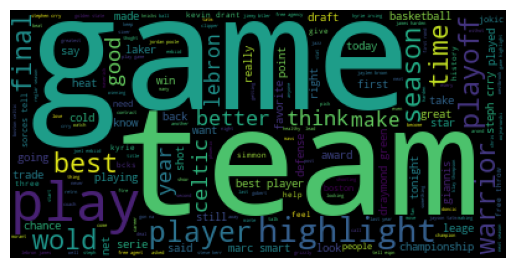

In [17]:
wc = WordCloud()
img = wc.generate_from_text(' '.join(lemma_words))
plt.imshow(img)
plt.axis('off')
plt.show()

In [18]:
# Negative 
pos_lines = list(df_title[df_title.label == -1].headline)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(10)

[('game', 931),
 ('warriors', 374),
 ('team', 359),
 ('worst', 317),
 ('celtics', 315),
 ('season', 300),
 ('finals', 298),
 ('highlight', 296),
 ('points', 264),
 ('post', 235)]

In [19]:
# Normalization
wml = WordNetLemmatizer()
lemma_words=[]
for word in pos_tokens:
    tokens = wml.lemmatize(word)
    lemma_words.append(tokens)
    
lemma_freq = nltk.FreqDist(lemma_words)

lemma_freq.most_common(10)

[('game', 1124),
 ('team', 458),
 ('player', 416),
 ('playoff', 396),
 ('warrior', 380),
 ('point', 362),
 ('season', 344),
 ('final', 333),
 ('celtic', 320),
 ('highlight', 319)]

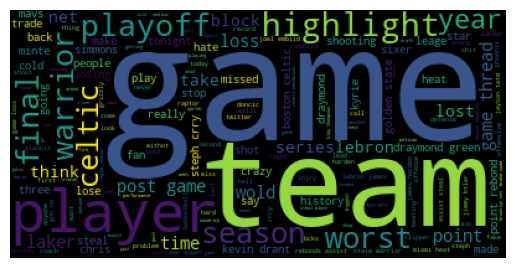

In [20]:
wc = WordCloud()
img = wc.generate_from_text(' '.join(lemma_words))
plt.imshow(img)
plt.axis('off')
plt.show()

## Topic Modeling 

In [21]:
tokenize_word = process_text(list(df_title.headline))

wml = WordNetLemmatizer()
data_lemmatized=[]
for word in tokenize_word :
    tokens = wml.lemmatize(word)
    data_lemmatized.append(tokens)
    
# Create Dictionary 
id2word = corpora.Dictionary([data_lemmatized])
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow([text]) for text in texts]  

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
for index, topic in lda_model.show_topics(formatted=False, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

Topic: 0 
Words: ['talent', 'team', 'year', 'free', 'brnson', 'mrray', 'deal', 'draft', 'contract', 'sign']
Topic: 1 
Words: ['wold', 'pick', 'leage', 'game', 'espn', 'wojnarowski', 'sprs', 'james', 'last', 'kevin']
Topic: 2 
Words: ['sorces', 'trade', 'kyrie', 'million', 'knicks', 'net', 'irving', 'option', 'make', 'like']
Topic: 3 
Words: ['first', 'next', 'best', 'lebron', 'star', 'hawk', 'westbrook', 'going', 'made', 'career']
Topic: 4 
Words: ['player', 'season', 'tell', 'agent', 'cold', 'harden', 'point', 'jalen', 'smith', 'trae']


In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=[data_lemmatized], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
#Higher the topic coherence, the topic is more human interpretable.


Perplexity:  -8.942664370173455

Coherence Score:  0.3111974634885624


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds')
vis

/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: Deprecatio

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.123247  0.329845       1        1  33.465365
2     -0.051862 -0.328669       2        1  25.211131
4     -0.285152 -0.030794       3        1  23.024928
1      0.247140 -0.119383       4        1   9.790038
3      0.213120  0.149002       5        1   8.508539, topic_info=            Term         Freq        Total Category  logprob  loglift
10766     player  3963.000000  3963.000000  Default  30.0000  30.0000
14254     talent  5324.000000  5324.000000  Default  29.0000  29.0000
15865       wold  2308.000000  2308.000000  Default  28.0000  28.0000
10673       pick  2268.000000  2268.000000  Default  27.0000  27.0000
8029       leage  2202.000000  2202.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
14722    tonight    49.459920    50.263317   Topic5  -6.2308   2.4480
14774      total    64.024195    65.722180   Topic5  -5.9727   2.4379
3596     dejonte   151.257803  1338.842438   Topic5  -5.1130   0.2835
11433  qalifying   105.297355   790.038046   Topic5  -5.4752   0.4488
3385      danilo    66.346822   360.946727   Topic5  -5.9371   0.7703

[192 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
252        1  0.998884       agency
254        3  0.999441        agent
547        4  0.995393      another
583        3  0.998194      antonio
863        3  0.997376      atlanta
...      ...       ...          ...
15848      3  0.886767       wizard
15863      4  0.999289  wojnarowski
15865      4  0.999836         wold
16013      1  0.999616         year
16036      1  0.999197         yong

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])